# DNS Ad-Blocker Training

Train XGBoost model to block ads at DNS level using domain name features.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from enhanced_dns_features import EnhancedDNSFeatureExtractor as DNSFeatureExtractor
from tqdm.auto import tqdm

np.random.seed(42)
print("Libraries loaded")

Libraries loaded


/usr/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Dataset

In [2]:
df = pd.read_csv('../Data/dns_training_data.csv')

print(f"Total domains: {len(df):,}")
print(f"\nLabel distribution:")
print(df['label'].value_counts())
print(f"\nSample:")
print(df.head(10))

Total domains: 198,162

Label distribution:
label
0    99081
1    99081
Name: count, dtype: int64

Sample:
                           domain  label
0                 offerstrack.net      0
1     cheapapartmentsaroundme.com      1
2              laxtrb.112.2o7.net      1
3  freewarepalm.uk.intellitxt.com      1
4                    finicity.com      0
5                      neogov.net      0
6                     hwqloan.com      1
7                     s5idnmc.top      1
8                           dm.de      0
9                   clearrate.com      0


## Extract Features

In [3]:
extractor = DNSFeatureExtractor()

print("Extracting features from 198k domains...\n")

features_list = []
for domain in tqdm(df['domain'], desc="Extracting"):
    try:
        features = extractor.extract_features(domain)
        features_list.append(features)
    except:
        features_list.append({})

features_df = pd.DataFrame(features_list)

print(f"\nFeatures extracted: {features_df.shape[1]}")
print(f"\nSample:")
print(features_df.head())

Extracting features from 198k domains...



Extracting: 100%|██████████| 198162/198162 [00:17<00:00, 11374.46it/s]



Features extracted: 68

Sample:
   domain_length  domain_name_length  subdomain_length  subdomain_count  \
0             15                  11                 0                0   
1             27                  23                 0                0   
2             18                   3                10                2   
3             30                  10                15                2   
4             12                   8                 0                0   

   path_depth  digit_count  digit_ratio  hyphen_count  hyphen_ratio  \
0           1            0     0.000000             0           0.0   
1           1            0     0.000000             0           0.0   
2           3            5     0.277778             0           0.0   
3           3            0     0.000000             0           0.0   
4           1            0     0.000000             0           0.0   

   underscore_count  ...  tld_is_country_code  tld_is_new_gtld  \
0                 0  ..

In [4]:
X = features_df.fillna(0)
y = df['label']

print(f"Feature matrix: {X.shape}")
print(f"Labels: {y.shape}")

Feature matrix: (198162, 68)
Labels: (198162,)


## Train-Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training: {len(X_train):,} samples")
print(f"Test: {len(X_test):,} samples")

Training: 158,529 samples
Test: 39,633 samples


## Train XGBoost Model

In [6]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',
    'max_depth': 8,
    'learning_rate': 0.05,
    'min_child_weight': 3,
    'eval_metric': 'logloss',
    'seed': 42,
    'tree_method': 'hist',
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
}

evals = [(dtrain, 'train'), (dtest, 'test')]
evals_result = {}

print("Training...\n")

model = xgb.train(
    params,
    dtrain,
    num_boost_round=200,
    evals=evals,
    evals_result=evals_result,
    early_stopping_rounds=20,
    verbose_eval=20
)

print("\nTraining complete")

Training...

[0]	train-logloss:0.66424	test-logloss:0.66412
[20]	train-logloss:0.39888	test-logloss:0.39731
[40]	train-logloss:0.33104	test-logloss:0.32953
[60]	train-logloss:0.30892	test-logloss:0.30815
[80]	train-logloss:0.30010	test-logloss:0.30037
[100]	train-logloss:0.29599	test-logloss:0.29717
[120]	train-logloss:0.29353	test-logloss:0.29557
[140]	train-logloss:0.29153	test-logloss:0.29454
[160]	train-logloss:0.28983	test-logloss:0.29391
[180]	train-logloss:0.28873	test-logloss:0.29365
[199]	train-logloss:0.28730	test-logloss:0.29328

Training complete


## Training Loss Curve

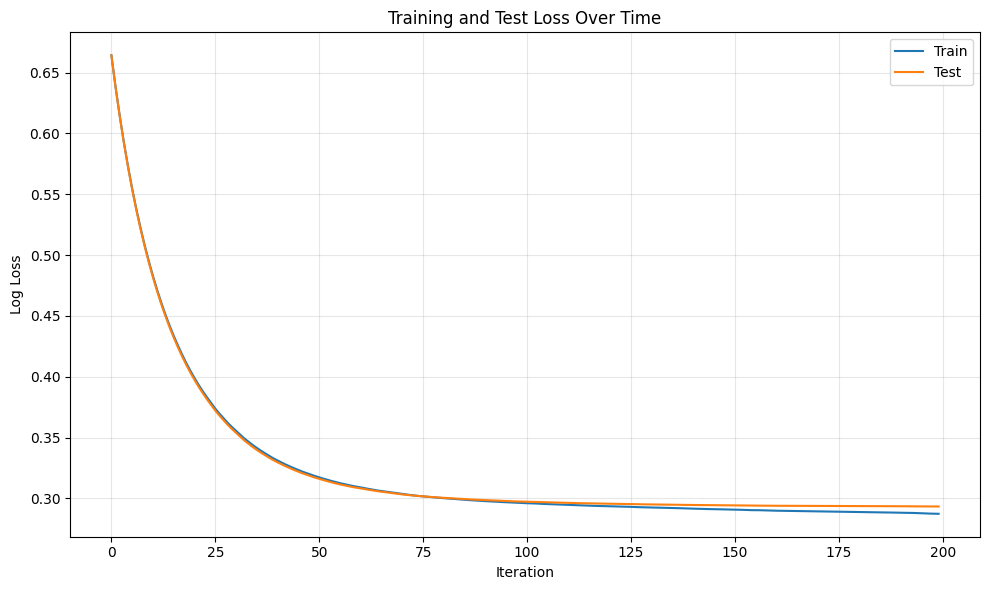

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(evals_result['train']['logloss'], label='Train')
plt.plot(evals_result['test']['logloss'], label='Test')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Training and Test Loss Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('loss_curve.png', dpi=150)
plt.show()

## Evaluate Performance

In [8]:
y_pred_proba = model.predict(dtest)
y_pred = (y_pred_proba > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("="*60)
print("MODEL PERFORMANCE")
print("="*60)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
print("="*60)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Ad']))

MODEL PERFORMANCE
Accuracy:  0.8699 (86.99%)
Precision: 0.9300 (93.00%)
Recall:    0.8000 (80.00%)
F1-Score:  0.8601 (86.01%)

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.82      0.94      0.88     19817
          Ad       0.93      0.80      0.86     19816

    accuracy                           0.87     39633
   macro avg       0.88      0.87      0.87     39633
weighted avg       0.88      0.87      0.87     39633



## Confusion Matrix

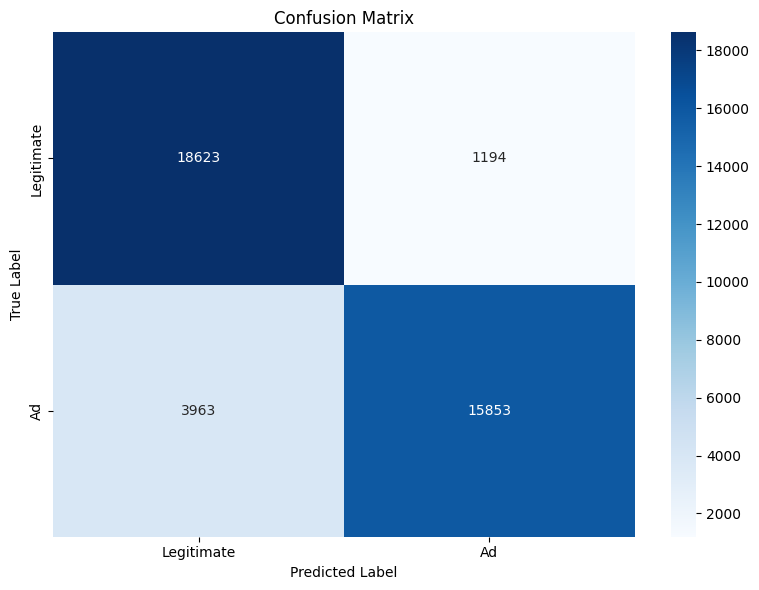

False Positive Rate: 0.0603 (6.03%)
False Negative Rate: 0.2000 (20.00%)


In [9]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Legitimate', 'Ad'],
            yticklabels=['Legitimate', 'Ad'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print(f"False Positive Rate: {fpr:.4f} ({fpr*100:.2f}%)")
print(f"False Negative Rate: {fnr:.4f} ({fnr*100:.2f}%)")

## Feature Importance

Top 15 Features:
                   feature  importance            feature_name
12     domain_name_entropy      1178.0     domain_name_entropy
11                 entropy      1157.0                 entropy
27       unique_char_ratio       987.0       unique_char_ratio
9          consonant_ratio       979.0         consonant_ratio
10             vowel_ratio       814.0             vowel_ratio
25  max_consonant_sequence       723.0  max_consonant_sequence
44   vowel_consonant_ratio       696.0   vowel_consonant_ratio
39      alphanumeric_ratio       652.0      alphanumeric_ratio
37    domain_to_full_ratio       614.0    domain_to_full_ratio
0            domain_length       511.0           domain_length
19              tld_length       494.0              tld_length
38       tld_to_full_ratio       454.0       tld_to_full_ratio
6              digit_ratio       436.0             digit_ratio
40     max_char_repetition       393.0     max_char_repetition
20       is_commercial_tld       358.0

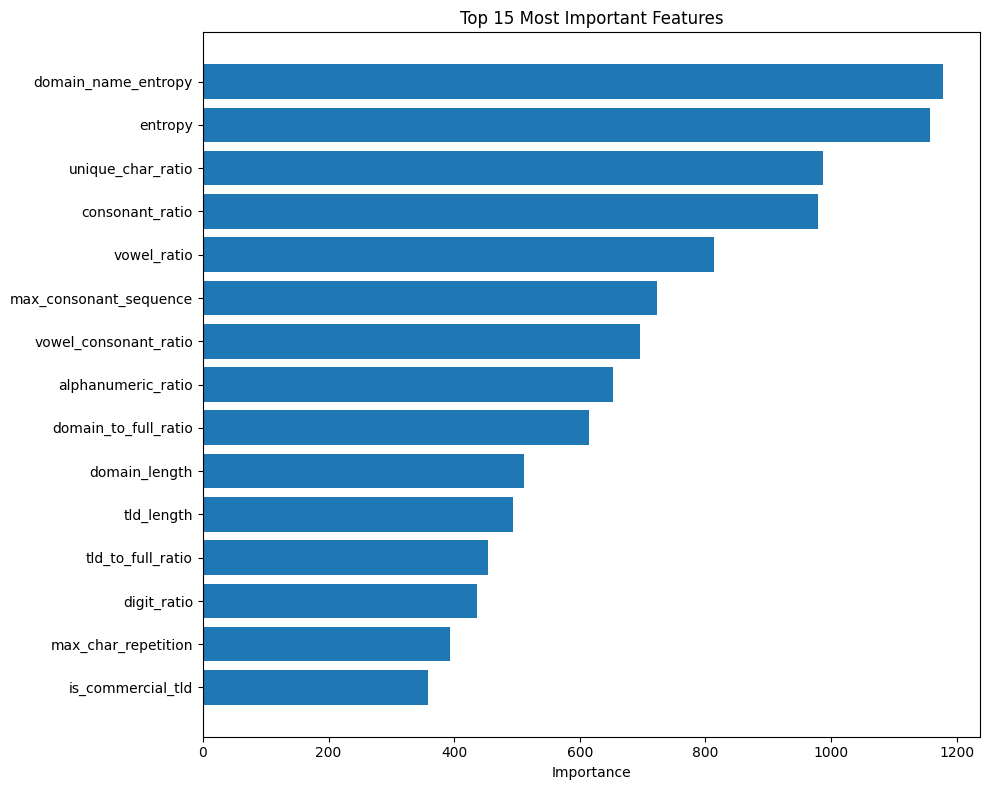

In [10]:
importance = model.get_score(importance_type='weight')

feature_importance = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
}).sort_values('importance', ascending=False)

feature_names = X.columns.tolist()
feature_importance['feature_name'] = feature_importance['feature'].apply(
    lambda x: feature_names[int(x.replace('f', ''))] if x.startswith('f') else x
)

print("Top 15 Features:")
print(feature_importance.head(15))

plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature_name'])
plt.xlabel('Importance')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150)
plt.show()

## Test on Real Domains

In [11]:
test_domains = [
    'googleads.g.doubleclick.net',
    'pagead2.googlesyndication.com',
    'static.ads-twitter.com',
    'an.facebook.com',
    'adservice.google.com',
    'www.google.com',
    'api.github.com',
    'www.wikipedia.org',
    'mail.yahoo.com',
    'www.reddit.com'
]

print("Testing on example domains:\n")
print("="*70)

for domain in test_domains:
    features = extractor.extract_features(domain)
    features_vec = pd.DataFrame([features])[X.columns].fillna(0)
    dmatrix = xgb.DMatrix(features_vec)
    pred_proba = model.predict(dmatrix)[0]
    prediction = "AD" if pred_proba > 0.5 else "LEGITIMATE"
    
    print(f"{domain:45s} -> {prediction:12s} ({pred_proba:.3f})")

print("="*70)

Testing on example domains:

googleads.g.doubleclick.net                   -> AD           (1.000)
pagead2.googlesyndication.com                 -> AD           (1.000)
static.ads-twitter.com                        -> AD           (1.000)
an.facebook.com                               -> AD           (1.000)
adservice.google.com                          -> AD           (1.000)
www.google.com                                -> AD           (1.000)
api.github.com                                -> AD           (1.000)
www.wikipedia.org                             -> AD           (1.000)
mail.yahoo.com                                -> AD           (1.000)
www.reddit.com                                -> AD           (1.000)


## Save Model

In [12]:
model.save_model('dns_adblocker_model.ubj')
model.save_model('dns_adblocker_model.json')

import json
with open('feature_names.json', 'w') as f:
    json.dump(X.columns.tolist(), f, indent=2)

import os
ubj_size = os.path.getsize('dns_adblocker_model.ubj') / 1024
json_size = os.path.getsize('dns_adblocker_model.json') / 1024

print("Model saved:")
print(f"  dns_adblocker_model.ubj ({ubj_size:.1f} KB)")
print(f"  dns_adblocker_model.json ({json_size:.1f} KB)")
print(f"  feature_names.json")
print(f"\nModel ready for deployment")

Model saved:
  dns_adblocker_model.ubj (1106.4 KB)
  dns_adblocker_model.json (1764.4 KB)
  feature_names.json

Model ready for deployment
